# Connect to PI Web API and SLTC database and create dataframe

# Develop initial model using obvious predictors

In [1]:
import json
import getpass
import requests
import pandas as pd
import numpy as np
import urllib3
import datetime
import dateutil.parser
import sklearn
import matplotlib
import types
import uuid
import io

urllib3.disable_warnings()
from requests.auth import HTTPBasicAuth

from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn import neighbors
from matplotlib import pyplot as plt

In [2]:
# This cell does most of the data obtaining and cleanup work. It first connects to the PI System via PI Web API 
# using basic/kerberos authentication where in it gets maximum 1000 eventframes which fit our criteria. 


""" Create API call security method
        @param security_method string:  security method to use:  basic or kerberos
        @param user_name string: The user's credentials name
        @param user_password string: The user's credentials password
"""
def read_config():
    with open('test_config.json') as c:
        config = json.load(c)
    return config
        
def call_security_method(security_method, user_name, user_password):
    
    if security_method.lower() == 'basic':
        security_auth = HTTPBasicAuth(user_name, user_password)
        
    return security_auth

""" Method to send HTTP GET requests
        @param query:  query string to execute
        Also uses the test_config.json file to read the username and password for Basic Authentication
"""
def get(query):
    
    data = read_config()
    username = data['Username']
    password = data['Password']
    securitymethod = data.get('AuthType', 'basic')
    verify_ssl = data.get('VerifySSL', True)
    
    security_auth = call_security_method(securitymethod, username, password)
    response = requests.get(query, auth=security_auth, verify=verify_ssl)
    return response

""" Method to send HTTP POST requests
        @param query:  query string to execute
        @param body: body of the request 
        Also uses the test_config.json file to read the username and password for Basic Authentication
"""
def post(query, body):
    
    header = {
        'content-type': 'application/json',
        'X-Requested-With':'XmlHttpRequest'
    }
    
    data = read_config()
    username = data['Username']
    password = data['Password']
    securitymethod = data.get('AuthType', 'basic')
    verify_ssl = data.get('VerifySSL', True)
    
    security_auth = call_security_method(securitymethod, username, password)
    response = requests.post(query, auth=security_auth, verify=verify_ssl, json=body, headers=header)
    return response

""" Method to send HTTP DELETE requests
        @param query:  query string to execute
        Also uses the test_config.json file to read the username and password for Basic Authentication
"""
def delete(query):
    data = read_config()
    username = data['Username']
    password = data['Password']
    securitymethod = data.get('AuthType', 'basic')
    verify_ssl = data.get('VerifySSL', True)

    security_auth = call_security_method(securitymethod, username, password)
    response = requests.delete(query, auth=security_auth, verify=verify_ssl)
    return response

""" Method to get the database web ID of a given database path
        @param path: path of the database. More info can be found here: https://your-server/piwebapi/help/topics/path-syntax
"""
def getDatabaseWebID(path):
    data = read_config()
    piwebapi_url = data['Resource']
    getDatabaseQuery = piwebapi_url + "/assetdatabases?path=" + path
    database = json.loads(get(getDatabaseQuery).text)
    return database['WebId']
    

#get database WebID

data = read_config()
databasePath = "\\\\"+ data['AssetServerName'] + "\\" + data['AssetDatabaseName']
databaseWebID = getDatabaseWebID(databasePath)



# This query is built for targeting the PI Web API EventFrame Search endpoint.
# More information can be found under : https://your-server/piwebapi/help/controllers/eventframe/actions/geteventframesquery
# In this particular case, we are looking for 1000 eventframes which are part of VAVCO startup template and which ocurred during
# the past year. That explains our query parameters of template, startTime, endTime and maxCount.
# Additionally, we are looking for eventframes which have the duration less than 2 hours so that we can count out anamolies for
# the purpose of cleaning up our dataset. That is why we decided to use the query feature of the search endpoints.
# More information about query syntax can be found here : https://your-server/piwebapi/help/topics/search-query-syntax
piwebapi_url = data['Resource']
getEFQuery = piwebapi_url + "/eventframes/search?databaseWebId="+\
                databaseWebID + "&template=VAVCO%20startup&startTime=*-1d&endTime=*+1d&maxCount=1000&query=duration:<2h"

#send GET request to PI Web API
response = get(getEFQuery)
data = json.loads(response.text)

items = data['Items']

#initalizing predictor arrays
efarray = []
setpoint = []
percentcooling = []
isMonday = []
dayofweek = []
outsideairtemp = []
outsidehumidity = []

#target variable
duration = []

for i in items:
    attributes_response = get(i['Links']['Attributes'])
    attributes = json.loads(attributes_response.text) #attributes
    attribute_items = attributes['Items']

    #Add eventframe name to the dataframe
    efarray.append(i['Name'])
    
    #parse Time
    startTime = dateutil.parser.parse(i['StartTime'])
    endTime = dateutil.parser.parse(i['EndTime'])
    
    #add target duration in minutes
    elapsedTime = endTime-startTime
    duration.append(elapsedTime.seconds/60)
    
    
    
    for j in attribute_items:
        #add predictors to data frame

        if j['Name'] == 'Setpoint Offset at start time':
            value_response = get(j['Links']['Value'])
            setpoint.append(json.loads(value_response.text)['Value'])
        if j['Name'] == '% Cooling at VAV Start':
            value_response = get(j['Links']['Value'])
            percentcooling.append(json.loads(value_response.text)['Value'])
        if j['Name'] == 'Outside Relative Humidity at VAV Start':
            value_response = get(j['Links']['Value'])
            outsidehumidity.append(json.loads(value_response.text)['Value'])
        if j['Name'] == 'Outside Air Temperature at VAV Start':
            value_response = get(j['Links']['Value'])
            outsideairtemp.append(json.loads(value_response.text)['Value'])
    
    #add IsMonday predictor 
    if startTime.weekday() == 0:
        isMonday.append(1)
    else:
        isMonday.append(0)
    
    dayofweek.append(startTime.weekday())
        

df = pd.DataFrame({
    'VAVCO Startup' : efarray,
    'Setpoint Offset at start time' : setpoint,
    '% Cooling at VAV Start' : percentcooling,
    'IsMonday' : isMonday,
    'Duration' : duration,
    'Day of Week' : dayofweek,
    'Outside Relative Humidity at VAV Start' : outsidehumidity,
    'Outside Air Temperature at VAV Start' : outsideairtemp
})

df.head()        

,VAVCO Startup,Setpoint Offset at start time,% Cooling at VAV Start,IsMonday,Duration,Day of Week,Outside Relative Humidity at VAV Start,Outside Air Temperature at VAV Start
0,VAVCO startup - VAVCO 4-15 - 2020-03-26 03:51:...,1.0,20.399990,0,14.983333,3,76.271141,43.070553
1,VAVCO startup - VAVCO 4-03 - 2020-03-26 03:51:...,1.0,19.816669,0,14.983333,3,76.270699,43.070583
2,VAVCO startup - VAVCO 6-09 - 2020-03-26 04:21:...,1.0,19.850000,0,14.900000,3,80.403786,41.943401
3,VAVCO startup - VAVCO 3-10 - 2020-03-26 05:51:...,2.5,38.949989,0,45.000000,3,80.150864,41.070553
4,VAVCO startup - VAVCO 3-09 - 2020-03-26 05:51:...,3.5,51.683311,0,75.000000,3,80.150780,41.070557


In [3]:
X = df[['Outside Air Temperature at VAV Start', 'Outside Relative Humidity at VAV Start']]

Y = df['Duration'] 
    
x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.3)


#Using Linear Regression
regr1 = linear_model.LinearRegression() 
regr1.fit(x_train, y_train) 
print(regr1.score(x_test, y_test))

0.025128280727730212


# Develop model with better predictors

In [4]:
X = df[['% Cooling at VAV Start', 'Setpoint Offset at start time', 'IsMonday']]

Y = df['Duration'] 
    
x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.3)


#Using Linear Regression
regr = linear_model.LinearRegression() 
regr.fit(x_train, y_train) 
print(regr.score(x_test, y_test))

0.34890771617327876


# Phase 2 : Predict for real-time predictors 

In [5]:
def read_config():
    with open('test_config.json') as c:
        config = json.load(c)
    return config

data = read_config()

# query elements

databasePath = "\\\\"+ data['AssetServerName'] + "\\" + data['AssetDatabaseName']
databaseWebID = getDatabaseWebID(databasePath)
piwebapi_url = data['Resource']

query = piwebapi_url + "/assetdatabases/"+ databaseWebID + "/elements?templateName=VAVCO&searchFullHierarchy=true"
elemResponse = get(query)


data = json.loads(elemResponse.text)

items = data['Items']

for i in items:
    attributes_response = get(i['Links']['Attributes'])
    attributes = json.loads(attributes_response.text) #attributes
    attribute_items = attributes['Items']
    
    
    for j in attribute_items:
        if j['Name']== '% cooling':
            value_response = get(j['Links']['Value'])
            percentcooling = json.loads(value_response.text)['Value']
        if j['Name']== 'Setpoint Offset Current':
            value_response = get(j['Links']['Value'])
            setpoint = json.loads(value_response.text)['Value']
    
       
    if datetime.datetime.now().weekday() == 0:
        isMonday = 1
    else:
        isMonday = 0

    
    #clean up data: only predict if the value of predictors is greater than 0 and not a dictionary(NODATA case);
    
    if isinstance(percentcooling, float):
        if percentcooling > 0.0:
            forecast = regr.predict([[percentcooling, setpoint, isMonday]])
            print(forecast)
            
            # data ingress using pi web api
            body = {'Value' : forecast[0]}
            for j in attribute_items:        
                if j['Name']=='Predicted Cooling Time':
                    query = piwebapi_url + "/streams/"+ j['WebId']+ "/value"
                    response = post(query, body)
                    print(response.status_code)

[42.64836358]
202
[58.29999381]
202


# Scatter Plots

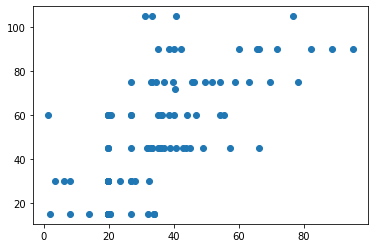

In [6]:
plt.scatter(df['% Cooling at VAV Start'], df['Duration'])

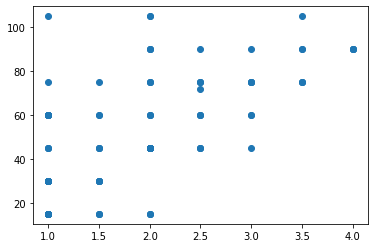

In [7]:
plt.scatter(df['Setpoint Offset at start time'], df['Duration'])

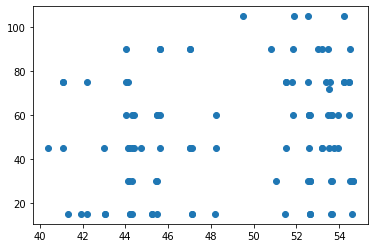

In [8]:
plt.scatter(df['Outside Air Temperature at VAV Start'], df['Duration'])
global finished
finished = True

In [9]:
def test_finished():
    global finished
    
    assert finished